In [2]:
# import libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [3]:
df = pd.read_excel("C:/Users/Ruben/Datasets/SWAT/SWaT_Dataset_Attack_v0.xlsx")

df.columns = [
	'TIMESTAMP','FIT101','LIT101','MV101','P101','P102','AIT201','AIT202','AIT203','FIT201','MV201','P201','P202','P203',
    'P204','P205','P206','DPIT301','FIT301','LIT301','MV301','MV302','MV303','MV304','P301','P302','AIT401','AIT402','FIT401',
    'LIT401','P401','P402','P403','P404','UV401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504',
    'P501','P502','PIT501','PIT502','PIT503','FIT601','P601','P602','P603','OUTCOME'
]

# The first row only contains labels
# 'TIMESTAMP' is irrelevant for the thesis
# The other dropped columns contain either only 0s, only 1s or only 2s and are therefore irrelevant

df = df.iloc[1:]
df = df.drop(['TIMESTAMP', 'P202', 'P301', 'P401', 'P404', 'P502', 'P601', 'P603'], axis = 1)

# The dataset labels attacks by 'A ttack' and 'Attack', and labels normal data as 'Normal'
# To keep the same structure in all datasets, the 'A ttack' and 'Attack' values are changed to '-1' and normal values to '1'

df['OUTCOME'].replace(to_replace = ['A ttack', 'Attack'], value = 1, inplace = True)
df['OUTCOME'].replace(to_replace = ['Normal'], value = 0, inplace = True)

# data types need to be numeric to be encoded to z-scores --> convert column object data types to numerics

cols = df.columns[df.columns != 'OUTCOME']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Encoding the feature vectors to z-scores

cols = list(df.columns[df.columns != 'OUTCOME'])
for col in cols:
    df[col] = ((df[col] - df[col].mean())/df[col].std(ddof=0))

In [4]:
normal_mask = df[df.OUTCOME == 0]
attack_mask = df[df.OUTCOME == 1]

In [5]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 42)

X_train = X_train[X_train.OUTCOME == 0]
X_train = X_train.drop(['OUTCOME'], axis=1)

y_test = X_test['OUTCOME']
X_test = X_test.drop(['OUTCOME'], axis=1)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(316353, 44)
(89984, 44)
(89984,)


In [6]:
ae = model = Sequential()
model.add(Dense(35, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(X_train.shape[1]))

ae.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35)                1575      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1080      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                780       
_________________________________________________________________
dense_5 (Dense)              (None, 35)                1085      
_________________________________________________________________
dense_6 (Dense)              (None, 44)                1584      
Total params: 6,879
Trainable params: 6,879
Non-trainable params: 0
____________________________________________________

In [7]:
nb_epoch = 50
batch_size = 64

ae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.SWAT", verbose=0, save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = ae.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                 validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

Train on 316353 samples, validate on 89984 samples
Epoch 1/50
316353/316353 [==============================] - 21s 65us/step - loss: 0.0477 - accuracy: 0.7711 - val_loss: 0.3813 - val_accuracy: 0.5939
Epoch 2/50
316353/316353 [==============================] - 20s 62us/step - loss: 0.0145 - accuracy: 0.8687 - val_loss: 0.1943 - val_accuracy: 0.6975
Epoch 3/50
316353/316353 [==============================] - 20s 63us/step - loss: 0.0101 - accuracy: 0.8782 - val_loss: 0.1206 - val_accuracy: 0.8315
Epoch 4/50
316353/316353 [==============================] - 20s 63us/step - loss: 0.0081 - accuracy: 0.8843 - val_loss: 0.1225 - val_accuracy: 0.8384
Epoch 5/50
316353/316353 [==============================] - 20s 63us/step - loss: 0.0069 - accuracy: 0.8884 - val_loss: 0.0931 - val_accuracy: 0.8631
Epoch 6/50
316353/316353 [==============================] - 20s 63us/step - loss: 0.0063 - accuracy: 0.8951 - val_loss: 0.1134 - val_accuracy: 0.8778
Epoch 7/50
316353/316353 [=======================

In [8]:
ae = load_model('model.SWAT')

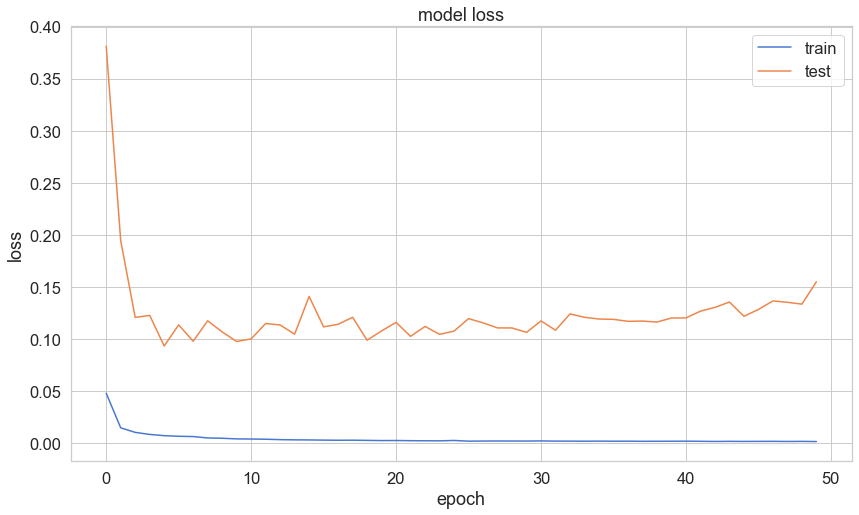

In [9]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
# plt.savefig('loss_SWAT_GoodModel.png')

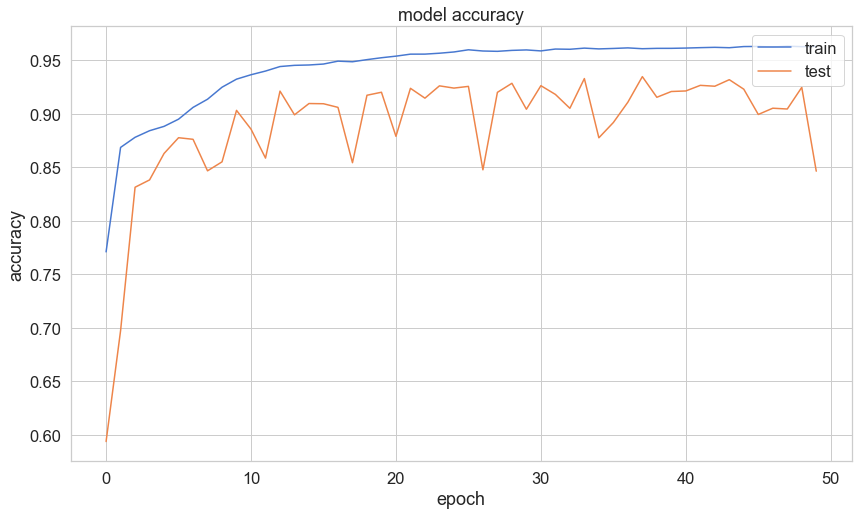

In [10]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
# plt.savefig('accuracy_SWaT_GoodModel.png')

In [11]:
#predictions = autoencoder1.predict(X_test)
predictions = ae.predict(X_test)

In [12]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [13]:
error_df.describe()

,reconstruction_error,true_class
count,89984.000000,89984.000000
mean,0.093134,0.122677
std,3.922728,0.328068
min,0.000175,0.000000
25%,0.000827,0.000000
50%,0.001232,0.000000
75%,0.002406,0.000000
max,409.113012,1.000000


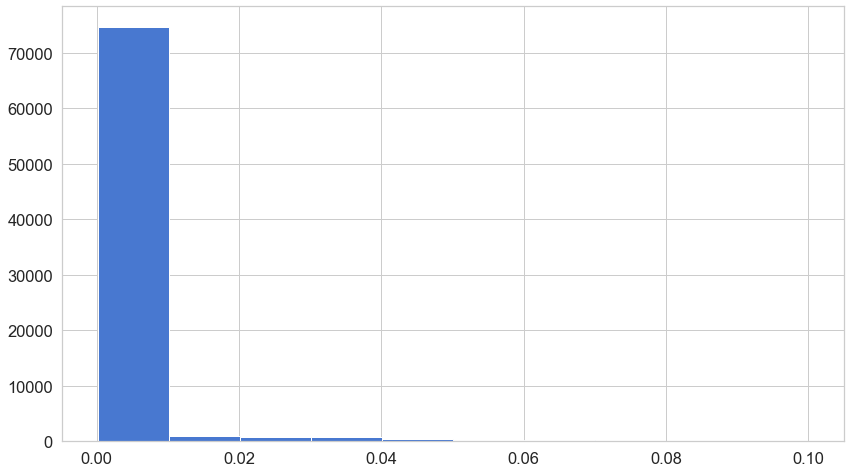

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 0.1)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

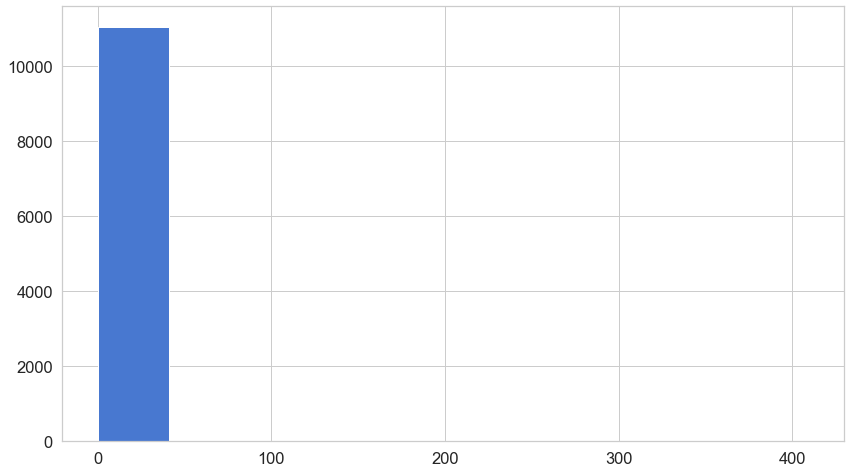

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [16]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

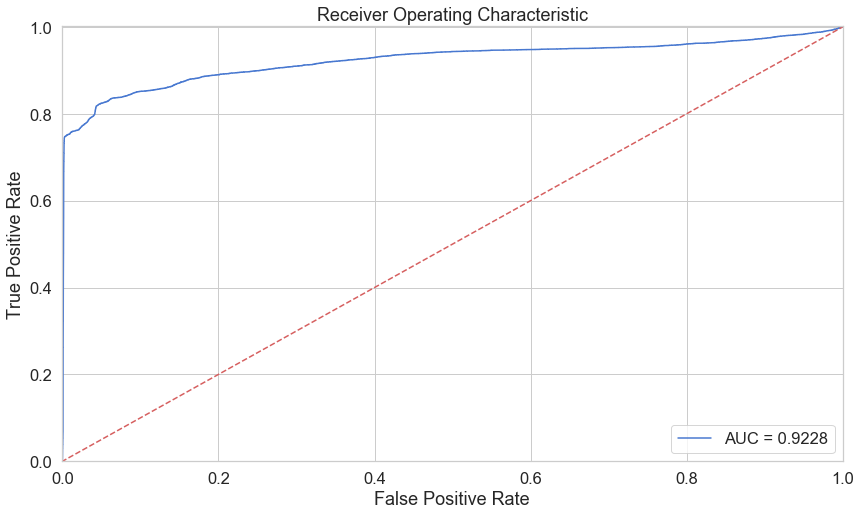

In [17]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([-1,1],[-1,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.savefig('ROC_SWAT2.png')
plt.show();

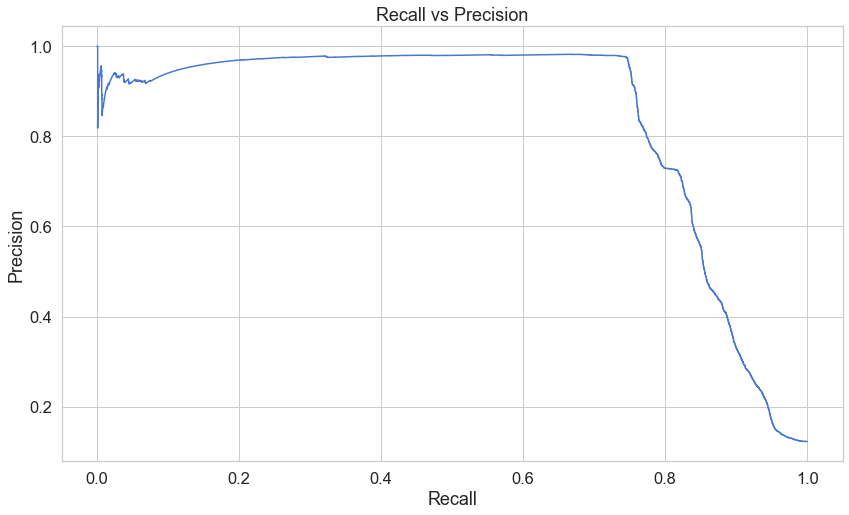

In [18]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
# high precision = low false positive
# high recall = low false negative 

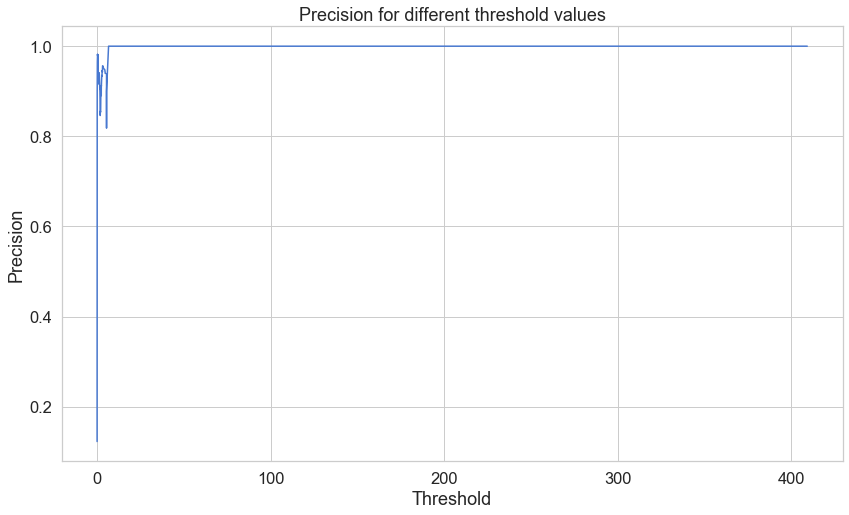

In [19]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
# plt.savefig('precision_threshold_SWAT.png')
plt.show()

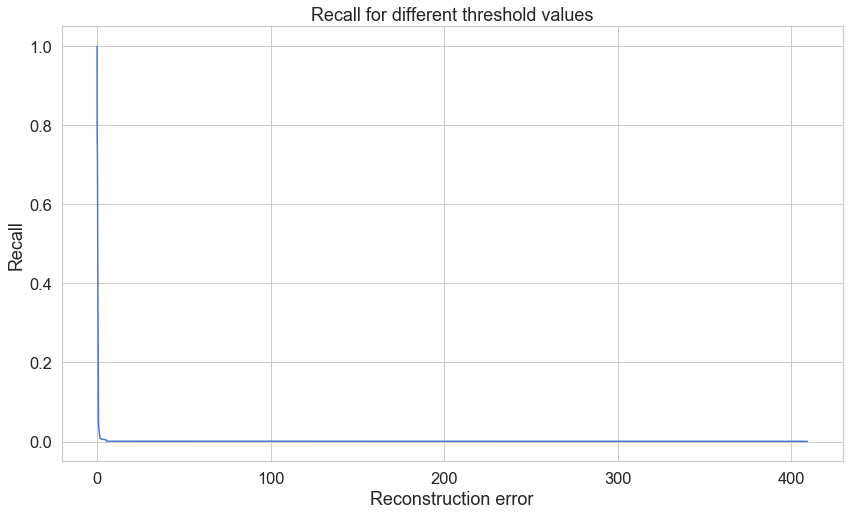

In [20]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [30]:
threshold = 0.03

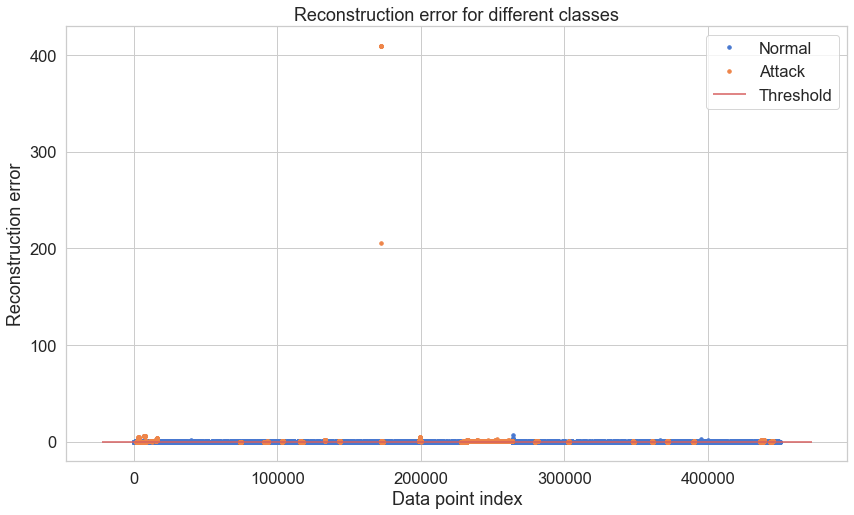

In [21]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
# plt.savefig('Threshold SWaT.png')

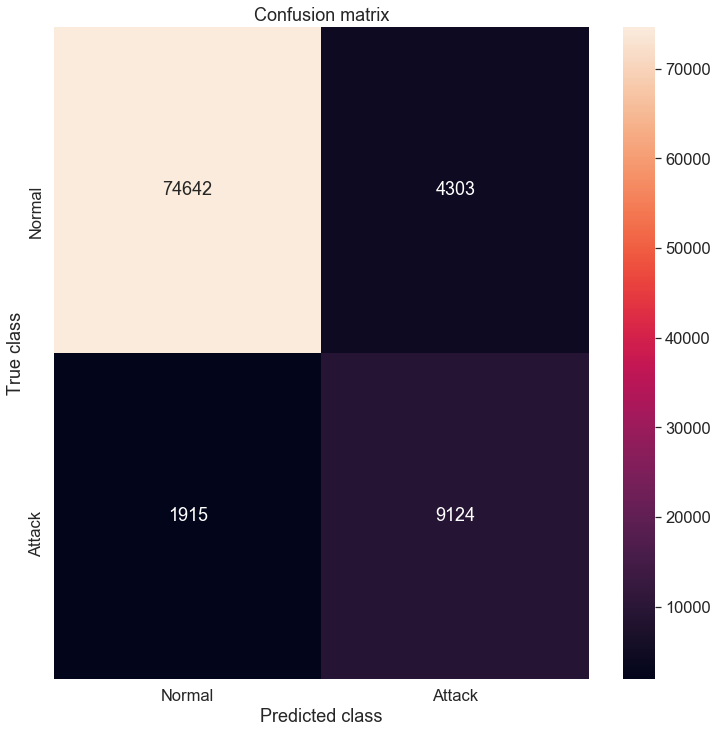

In [43]:
threshold = 0.01
LABELS = ["Normal", "Attack"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [39]:
# This is the numeric feature vector, as it goes to the neural net
x_normal = df_normal.values
x_attack = df_attack.values

In [40]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    x_normal, test_size=0.25, random_state=42)

In [41]:
print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 296473
Normal test count: 98825


In [42]:
# Create neural network architecture
model = Sequential()
model.add(Dense(150, input_dim=x_normal.shape[1], activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(x_normal.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=100)

Epoch 1/100
9265/9265 [==============================] - 21s 2ms/step - loss: 0.0429
Epoch 2/100
9265/9265 [==============================] - 21s 2ms/step - loss: 0.0255
Epoch 3/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0145
Epoch 4/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0123
Epoch 5/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0096
Epoch 6/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0075
Epoch 7/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0068
Epoch 8/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0063
Epoch 9/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0065
Epoch 10/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0055
Epoch 11/100
9265/9265 [==============================] - 22s 2ms/step - loss: 0.0051
Epoch 12/100
9265/9265 [==============================] - 22s 2

In [43]:
pred = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_normal_test))
pred = model.predict(x_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred,x_normal))
pred = model.predict(x_attack)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_attack))
print(f"Out of Sample Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Attack Underway Score (RMSE): {score3}")

Out of Sample Score (RMSE): 0.06179703632017953
Insample Normal Score (RMSE): 0.06069642186918363
Attack Underway Score (RMSE): 2.642082721493425


In [36]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(df)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P302,AIT401,AIT402,FIT401,LIT401,P402,P403,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,OUTCOME
1,0.598055,-0.671759,0.693861,0.66519,-0.083632,1.471045,-1.150243,0.501005,0.656905,0.655351,-0.37114,0.669201,-0.011157,0.668508,-0.011057,0.506541,0.543548,0.572369,-0.059685,0.558395,-0.128684,-0.312151,0.541989,0.551475,-0.131916,0.274596,0.583244,0.276889,-0.011549,0.283002,1.082496,-0.111686,-0.037017,-0.310733,0.271600,0.253514,0.294030,0.296326,0.282974,0.302690,1.542306,0.313488,-0.102994,-0.095828,1
2,0.614180,-0.671445,0.693861,0.66519,-0.083632,1.471045,-1.150243,0.501005,0.656905,0.655351,-0.37114,0.669201,-0.011157,0.668508,-0.011057,0.506541,0.545100,0.572369,-0.059685,0.558395,-0.128684,-0.312151,0.541989,0.551475,-0.131916,0.280018,0.583037,0.276889,-0.011549,0.283002,1.082496,-0.111686,-0.037017,-0.310733,0.271600,0.307534,0.294030,0.296326,0.282974,0.302690,1.542306,0.315175,-0.102994,-0.095828,1
3,0.650193,-0.671759,0.693861,0.66519,-0.083632,1.471045,-1.166987,0.501005,0.654184,0.655351,-0.37114,0.669201,-0.011157,0.668508,-0.011057,0.499097,0.545524,0.576348,-0.059685,0.558395,-0.128684,-0.312151,0.541989,0.551475,-0.131916,0.280018,0.582211,0.276889,-0.011549,0.283002,1.082496,-0.111686,-0.037017,-0.310733,0.270734,0.296729,0.294030,0.306616,0.282974,0.302949,1.542306,0.315175,-0.102994,-0.095828,1
4,0.688087,-0.670818,0.693861,0.66519,-0.083632,1.471045,-1.166987,0.501005,0.654184,0.655351,-0.37114,0.669201,-0.011157,0.668508,-0.011057,0.499097,0.545524,0.580329,-0.059685,0.558395,-0.128684,-0.312151,0.541989,0.551475,-0.131916,0.277163,0.581797,0.276889,-0.011549,0.283002,1.082496,-0.116469,-0.037017,-0.310733,0.270734,0.258144,0.294030,0.306616,0.282974,0.302949,1.542306,0.313825,-0.102994,-0.095828,1
5,0.717381,-0.666746,0.693861,0.66519,-0.083632,1.471045,-1.166987,0.501005,0.654865,0.655351,-0.37114,0.669201,-0.011157,0.668508,-0.011057,0.499097,0.545524,0.583811,-0.059685,0.558395,-0.128684,-0.312151,0.541989,0.551475,-0.131916,0.277163,0.584071,0.276889,-0.011549,0.283002,1.082496,-0.122452,-0.037017,-0.310733,0.270734,0.258144,0.294030,0.306616,0.282974,0.302949,1.542306,0.311464,-0.102994,-0.095828,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449915,0.709587,-0.698072,0.693861,0.66519,-0.083632,-1.200283,0.959112,-1.105097,0.669377,0.655351,2.69440,0.669201,-0.011157,0.668508,-0.011057,0.590498,0.532254,0.800688,-0.059685,0.558395,-0.128684,-0.312151,0.541989,-0.682855,-0.366258,0.256330,0.662806,0.276889,-0.011549,0.283002,-0.494808,-0.391604,-1.173337,0.037745,0.255170,0.281680,0.292003,0.281287,0.282974,0.307359,-0.359524,0.301339,-0.103797,-0.095828,1
449916,0.700449,-0.691180,0.693861,0.66519,-0.083632,-1.200283,0.959112,-1.105097,0.669377,0.655351,2.69440,0.669201,-0.011157,0.668508,-0.011057,0.590498,0.532254,0.801185,-0.059685,0.558395,-0.128684,-0.312151,0.541989,-0.682855,-0.366258,0.256330,0.664459,0.276889,-0.011549,0.283002,-0.494808,-0.391604,-1.173337,0.037745,0.250846,0.232678,0.292003,0.281287,0.282974,0.306062,-0.359524,0.299315,-0.103797,-0.095828,1
449917,0.685668,-0.688988,0.693861,0.66519,-0.083632,-1.200283,0.959112,-1.105097,0.669944,0.655351,2.69440,0.669201,-0.011157,0.668508,-0.011057,0.581814,0.531125,0.797207,-0.059685,0.558395,-0.128684,-0.312151,0.541989,-0.682855,-0.367404,0.258327,0.665079,0.276889,-0.011549,0.283002,-0.494808,-0.391604,-1.173337,0.037745,0.250846,0.223032,0.292003,0.281287,0.282974,0.306062,-0.359524,0.299315,-0.103797,-0.095828,1
449918,0.677068,-0.688674,0.693861,0.66519,-0.083632,-1.200283,0.959112,-1.105097,0.669944,0.655351,2.69440,0.669201,-0.011157,0.668508,-0.011057,0.577264,0.531125,0.796709,-0.059685,0.558395,-0.1

In [5]:
column_values = df[['OUTCOME']].values.ravel()
unique_values = pd.unique(column_values)
print(unique_values)

['1' '-1']


In [21]:
print (df.dtypes)

FIT101           float64
LIT101           float64
MV101              int64
P101               int64
P102               int64
AIT201           float64
AIT202           float64
AIT203           float64
FIT201           float64
MV201              int64
P201               int64
P202               int64
P203               int64
P204               int64
P205               int64
P206               int64
DPIT301          float64
FIT301           float64
LIT301           float64
MV301              int64
MV302              int64
MV303              int64
MV304              int64
P301               int64
P302               int64
AIT401           float64
AIT402           float64
FIT401           float64
LIT401           float64
P401               int64
P402               int64
P403               int64
P404               int64
UV401              int64
AIT501           float64
AIT502           float64
AIT503           float64
AIT504           float64
FIT501           float64
FIT502           float64
